# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

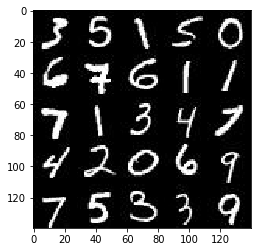

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

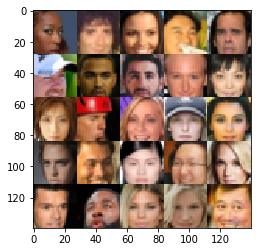

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
  
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28 28 3
        x1 = tf.layers.conv2d(images, 64, 3, 2, 'same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        leaky1 = tf.maximum(bn1, bn1 * alpha)
        # 14 14 64
        x2 = tf.layers.conv2d(leaky1, 128, 3, 2, 'same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        leaky2 = tf.maximum(bn2, bn2 * alpha)
        # 7 7 128
        
        flat = tf.reshape(leaky2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, 2, 'same')
        # 14 14 256
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, 2, 'same')
        # 28 28 out_channel_dim
        out = tf.tanh(x3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train=True) # What is the training parameter should be?
    real_out, real_logits = discriminator(input_real, reuse=False)
    fake_out, fake_logits = discriminator(input_fake, reuse=True) # This line has some bugs of scope.
    fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    return fake_loss+real_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

### Here we can try feature maching.

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    g_var = [var for var in variables if var.name.startswith('generator')]
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        g_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_var)
        d_loss_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_var)
    return d_loss_opt, g_loss_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [51]:
%pdb

Automatic pdb calling has been turned OFF


In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step = 0
    sample_z = np.random.uniform(-1, 1, (batch_size, z_dim))
    # input
    _, width, height, channels = data_shape
    input_real, input_z, lr  = model_inputs(width, height, channels, z_dim)
    # model loss
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    # model optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real:batch_images, lr:learning_rate})
                
                # Show the loss every 100 steps.
                if step % 25 == 0:
                    print('Step:', step,
                          'D loss:', d_loss.eval({input_real: batch_images, input_z: batch_z, lr:learning_rate}),
                          'G loss:', g_loss.eval({input_z: batch_z, lr:learning_rate}))
                if step % 400 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 25 D loss: 1.8108 G loss: 0.347639
Step: 50 D loss: 0.347991 G loss: 5.49167
Step: 75 D loss: 1.59836 G loss: 5.66105
Step: 100 D loss: 2.67212 G loss: 0.0827499
Step: 125 D loss: 2.25511 G loss: 3.4174
Step: 150 D loss: 1.93642 G loss: 0.174743
Step: 175 D loss: 0.700915 G loss: 2.08728
Step: 200 D loss: 1.69777 G loss: 0.230678
Step: 225 D loss: 0.27582 G loss: 1.8427
Step: 250 D loss: 0.172335 G loss: 2.3706
Step: 275 D loss: 0.0940494 G loss: 2.89532
Step: 300 D loss: 0.0626123 G loss: 3.36702
Step: 325 D loss: 0.121474 G loss: 2.53442
Step: 350 D loss: 0.0500309 G loss: 3.44467
Step: 375 D loss: 0.0496443 G loss: 3.4648
Step: 400 D loss: 0.0273781 G loss: 3.97649


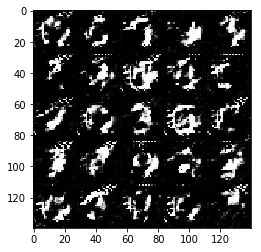

Step: 425 D loss: 0.0323213 G loss: 3.86699
Step: 450 D loss: 0.0426097 G loss: 3.70324
Step: 475 D loss: 0.0211362 G loss: 4.39772
Step: 500 D loss: 0.0124406 G loss: 4.86968
Step: 525 D loss: 0.0120792 G loss: 4.93994
Step: 550 D loss: 0.0112056 G loss: 4.92125
Step: 575 D loss: 0.0109518 G loss: 4.98829
Step: 600 D loss: 0.0105781 G loss: 5.0805
Step: 625 D loss: 0.00968929 G loss: 5.15571
Step: 650 D loss: 0.0124716 G loss: 4.79664
Step: 675 D loss: 0.00328392 G loss: 7.11594
Step: 700 D loss: 0.00366166 G loss: 6.33463
Step: 725 D loss: 0.00206433 G loss: 7.79271
Step: 750 D loss: 0.00329921 G loss: 6.80395
Step: 775 D loss: 0.00844093 G loss: 5.4203
Step: 800 D loss: 3.29233 G loss: 0.0581984


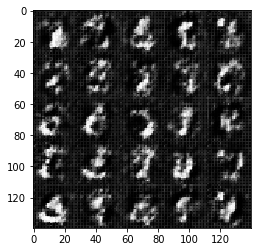

Step: 825 D loss: 0.631883 G loss: 2.79745
Step: 850 D loss: 0.342535 G loss: 1.60569
Step: 875 D loss: 0.207048 G loss: 2.0074
Step: 900 D loss: 0.0821897 G loss: 2.97794
Step: 925 D loss: 0.0533913 G loss: 3.26692
Step: 950 D loss: 0.0486684 G loss: 3.36648
Step: 975 D loss: 0.0391097 G loss: 3.64774
Step: 1000 D loss: 0.0209967 G loss: 4.24474
Step: 1025 D loss: 0.0195862 G loss: 4.47833
Step: 1050 D loss: 0.017756 G loss: 4.58268
Step: 1075 D loss: 0.015321 G loss: 4.76206
Step: 1100 D loss: 0.00885845 G loss: 5.28499
Step: 1125 D loss: 0.00814339 G loss: 5.52515
Step: 1150 D loss: 0.0156117 G loss: 4.64319
Step: 1175 D loss: 0.0137394 G loss: 4.91727
Step: 1200 D loss: 0.0121191 G loss: 5.46298


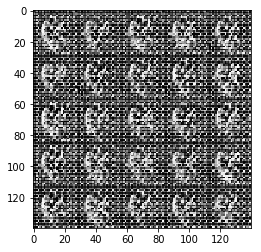

Step: 1225 D loss: 0.00420398 G loss: 6.40535
Step: 1250 D loss: 0.0033481 G loss: 6.8145
Step: 1275 D loss: 0.00250465 G loss: 6.78308
Step: 1300 D loss: 0.00204151 G loss: 9.07759
Step: 1325 D loss: 7.17391 G loss: 0.00177873
Step: 1350 D loss: 0.0422029 G loss: 5.015
Step: 1375 D loss: 0.0188583 G loss: 6.01345
Step: 1400 D loss: 0.0176009 G loss: 5.55161
Step: 1425 D loss: 0.0235872 G loss: 5.03287
Step: 1450 D loss: 0.00798318 G loss: 7.33415
Step: 1475 D loss: 0.0194372 G loss: 6.23689
Step: 1500 D loss: 0.015055 G loss: 6.55892
Step: 1525 D loss: 0.0283366 G loss: 5.94559
Step: 1550 D loss: 0.0313873 G loss: 4.88212
Step: 1575 D loss: 0.190362 G loss: 2.38578
Step: 1600 D loss: 0.121805 G loss: 3.51564


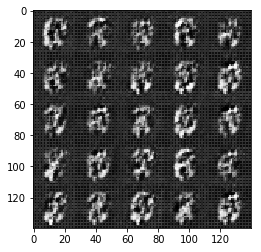

Step: 1625 D loss: 0.511185 G loss: 1.56277
Step: 1650 D loss: 0.116291 G loss: 4.47774
Step: 1675 D loss: 0.0466749 G loss: 4.03617
Step: 1700 D loss: 0.0755639 G loss: 3.33593
Step: 1725 D loss: 0.0704891 G loss: 3.49984
Step: 1750 D loss: 0.0216082 G loss: 6.10494
Step: 1775 D loss: 0.0153632 G loss: 5.92072
Step: 1800 D loss: 0.00822469 G loss: 6.64324
Step: 1825 D loss: 0.0120791 G loss: 6.84312
Step: 1850 D loss: 0.0198618 G loss: 6.11302
Step: 1875 D loss: 0.0149711 G loss: 8.91863
Step: 1900 D loss: 0.00904921 G loss: 9.69197
Step: 1925 D loss: 0.0280665 G loss: 5.05442
Step: 1950 D loss: 0.00905583 G loss: 7.08381
Step: 1975 D loss: 0.00484474 G loss: 9.67494
Step: 2000 D loss: 0.0061362 G loss: 6.44304


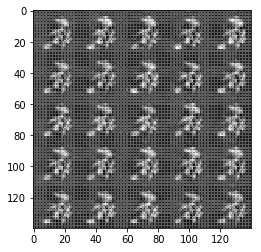

Step: 2025 D loss: 0.00226347 G loss: 10.0535
Step: 2050 D loss: 0.0097147 G loss: 7.48448
Step: 2075 D loss: 0.00643018 G loss: 9.69391
Step: 2100 D loss: 0.0060719 G loss: 8.20504
Step: 2125 D loss: 0.011936 G loss: 6.13693
Step: 2150 D loss: 0.00818166 G loss: 7.38017
Step: 2175 D loss: 0.0106413 G loss: 6.70369
Step: 2200 D loss: 0.00632532 G loss: 7.62464
Step: 2225 D loss: 0.00637066 G loss: 6.34308
Step: 2250 D loss: 0.00544053 G loss: 7.01541
Step: 2275 D loss: 0.058888 G loss: 4.43547
Step: 2300 D loss: 1.28248 G loss: 0.531985
Step: 2325 D loss: 0.595571 G loss: 1.47457
Step: 2350 D loss: 0.130753 G loss: 2.83941
Step: 2375 D loss: 0.0502642 G loss: 4.68844
Step: 2400 D loss: 0.0723225 G loss: 3.38557


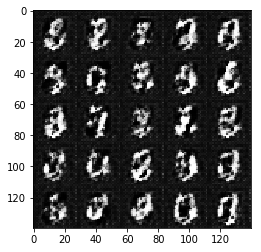

Step: 2425 D loss: 0.415418 G loss: 5.22596
Step: 2450 D loss: 0.235491 G loss: 2.28301
Step: 2475 D loss: 0.433286 G loss: 1.64634
Step: 2500 D loss: 0.0592465 G loss: 3.3515
Step: 2525 D loss: 0.0589128 G loss: 3.64537
Step: 2550 D loss: 0.0287467 G loss: 4.11184
Step: 2575 D loss: 0.0371665 G loss: 3.96739
Step: 2600 D loss: 0.0180596 G loss: 4.4577
Step: 2625 D loss: 0.0142274 G loss: 4.6622
Step: 2650 D loss: 0.0373778 G loss: 3.76037
Step: 2675 D loss: 0.00846895 G loss: 5.26231
Step: 2700 D loss: 0.00607798 G loss: 6.19901
Step: 2725 D loss: 0.00580489 G loss: 6.37195
Step: 2750 D loss: 0.00839868 G loss: 5.40311
Step: 2775 D loss: 0.00439489 G loss: 6.86969
Step: 2800 D loss: 0.0092795 G loss: 5.95089


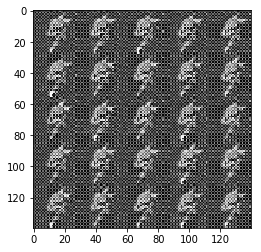

Step: 2825 D loss: 0.0100261 G loss: 5.90086
Step: 2850 D loss: 0.0116032 G loss: 9.63055
Step: 2875 D loss: 0.178393 G loss: 11.2715
Step: 2900 D loss: 0.0803028 G loss: 4.02261
Step: 2925 D loss: 0.0127276 G loss: 7.82007
Step: 2950 D loss: 0.0146376 G loss: 6.33258
Step: 2975 D loss: 0.0713628 G loss: 3.83066
Step: 3000 D loss: 0.00728785 G loss: 8.4467
Step: 3025 D loss: 0.0117057 G loss: 8.08788
Step: 3050 D loss: 0.00542234 G loss: 8.54885
Step: 3075 D loss: 0.0075894 G loss: 9.34408
Step: 3100 D loss: 0.0104329 G loss: 6.70057
Step: 3125 D loss: 0.0126774 G loss: 7.26845
Step: 3150 D loss: 0.0921025 G loss: 3.07799
Step: 3175 D loss: 0.187736 G loss: 2.17303
Step: 3200 D loss: 0.0152119 G loss: 7.27494


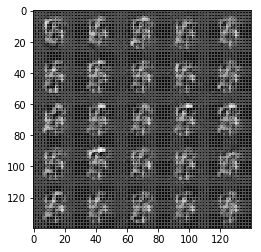

Step: 3225 D loss: 0.0167337 G loss: 5.48363
Step: 3250 D loss: 0.00696331 G loss: 8.33468
Step: 3275 D loss: 0.0113749 G loss: 5.55876
Step: 3300 D loss: 0.0284931 G loss: 4.8626
Step: 3325 D loss: 0.0960571 G loss: 3.65818
Step: 3350 D loss: 0.154682 G loss: 7.26242
Step: 3375 D loss: 0.0125367 G loss: 7.61091
Step: 3400 D loss: 0.0251876 G loss: 5.95243
Step: 3425 D loss: 0.0154292 G loss: 5.77024
Step: 3450 D loss: 0.0154287 G loss: 7.23975
Step: 3475 D loss: 0.00367986 G loss: 9.38597
Step: 3500 D loss: 0.00927948 G loss: 5.93093
Step: 3525 D loss: 0.0118904 G loss: 6.57625
Step: 3550 D loss: 0.00397686 G loss: 9.39334
Step: 3575 D loss: 0.0106389 G loss: 6.51688
Step: 3600 D loss: 0.00506855 G loss: 7.60811


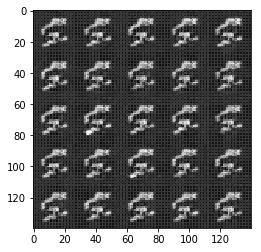

Step: 3625 D loss: 0.00923647 G loss: 6.18134
Step: 3650 D loss: 0.00195536 G loss: 7.83064
Step: 3675 D loss: 0.0243954 G loss: 4.67167
Step: 3700 D loss: 0.164342 G loss: 8.49908
Step: 3725 D loss: 0.0998839 G loss: 3.36707
Step: 3750 D loss: 0.0188171 G loss: 5.35267


In [55]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step: 25 D loss: 4.36911 G loss: 0.0301826
Step: 50 D loss: 3.20264 G loss: 0.0778193
Step: 75 D loss: 2.83682 G loss: 0.0990589
Step: 100 D loss: 2.07184 G loss: 0.182551
Step: 125 D loss: 1.44525 G loss: 0.360319
Step: 150 D loss: 2.45527 G loss: 0.10287
Step: 175 D loss: 1.69394 G loss: 0.639967
Step: 200 D loss: 1.85548 G loss: 0.421275
Step: 225 D loss: 1.67992 G loss: 0.287107
Step: 250 D loss: 1.65401 G loss: 0.403283
Step: 275 D loss: 0.68105 G loss: 1.16006
Step: 300 D loss: 0.790823 G loss: 1.16247
Step: 325 D loss: 0.524693 G loss: 1.5906
Step: 350 D loss: 0.666993 G loss: 1.26262
Step: 375 D loss: 0.499181 G loss: 1.51433
Step: 400 D loss: 0.341738 G loss: 2.35865


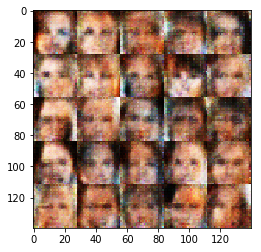

Step: 425 D loss: 3.20129 G loss: 3.72039
Step: 450 D loss: 0.157033 G loss: 3.13062
Step: 475 D loss: 0.157188 G loss: 2.53447
Step: 500 D loss: 0.110099 G loss: 2.89798
Step: 525 D loss: 1.83893 G loss: 0.204469
Step: 550 D loss: 0.261682 G loss: 1.93019
Step: 575 D loss: 0.227791 G loss: 2.25401
Step: 600 D loss: 0.162733 G loss: 2.3818
Step: 625 D loss: 0.174114 G loss: 2.71457
Step: 650 D loss: 0.0881306 G loss: 4.20908
Step: 675 D loss: 0.227025 G loss: 2.15443
Step: 700 D loss: 0.0763926 G loss: 3.80528
Step: 725 D loss: 3.69802 G loss: 1.9056
Step: 750 D loss: 1.19838 G loss: 0.522178
Step: 775 D loss: 0.232458 G loss: 2.47715
Step: 800 D loss: 0.272039 G loss: 3.07359


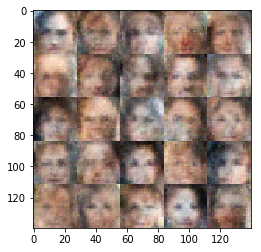

Step: 825 D loss: 0.397666 G loss: 2.49067
Step: 850 D loss: 0.260006 G loss: 2.11183
Step: 875 D loss: 0.799732 G loss: 3.17119
Step: 900 D loss: 0.881864 G loss: 0.70332
Step: 925 D loss: 0.343633 G loss: 1.70667
Step: 950 D loss: 0.138638 G loss: 3.01502
Step: 975 D loss: 0.152515 G loss: 3.02684
Step: 1000 D loss: 0.0864797 G loss: 3.62486
Step: 1025 D loss: 0.207087 G loss: 2.29121
Step: 1050 D loss: 0.0735506 G loss: 4.26012
Step: 1075 D loss: 0.156687 G loss: 5.36685
Step: 1100 D loss: 2.78538 G loss: 0.079228
Step: 1125 D loss: 2.14671 G loss: 0.184014
Step: 1150 D loss: 1.67899 G loss: 0.341593
Step: 1175 D loss: 2.49779 G loss: 0.106651
Step: 1200 D loss: 2.4492 G loss: 0.143063


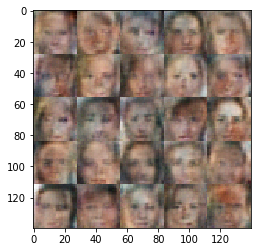

Step: 1225 D loss: 1.82161 G loss: 0.38181
Step: 1250 D loss: 1.73179 G loss: 0.367017
Step: 1275 D loss: 2.01979 G loss: 0.178796
Step: 1300 D loss: 1.74234 G loss: 0.260165
Step: 1325 D loss: 2.35662 G loss: 0.142404
Step: 1350 D loss: 0.869478 G loss: 1.15927
Step: 1375 D loss: 1.3246 G loss: 0.419369
Step: 1400 D loss: 0.702617 G loss: 0.928188
Step: 1425 D loss: 0.859355 G loss: 0.975359
Step: 1450 D loss: 0.421389 G loss: 2.0495
Step: 1475 D loss: 0.901161 G loss: 0.767809
Step: 1500 D loss: 1.44788 G loss: 0.475283
Step: 1525 D loss: 0.584883 G loss: 1.23341
Step: 1550 D loss: 0.533992 G loss: 1.2882
Step: 1575 D loss: 0.395416 G loss: 1.6989
Step: 1600 D loss: 0.354977 G loss: 2.08751


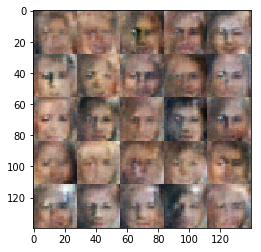

Step: 1625 D loss: 0.367128 G loss: 2.50915
Step: 1650 D loss: 0.608469 G loss: 1.09218
Step: 1675 D loss: 0.686362 G loss: 1.11582
Step: 1700 D loss: 1.02834 G loss: 0.523648
Step: 1725 D loss: 0.594616 G loss: 2.13304
Step: 1750 D loss: 0.392339 G loss: 1.56745
Step: 1775 D loss: 2.07415 G loss: 0.251293
Step: 1800 D loss: 1.27463 G loss: 0.488801
Step: 1825 D loss: 0.816214 G loss: 0.797467


In [58]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.